# GCIMS (R package) and gc-ims-tools(Python Package) Comparison for pre-processing urines sampled with GC-IMS


## IMPORT LIBRARIES

In [2]:
import ims
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn import metrics
from sklearn import decomposition
import multiprocessing
from joblib import Parallel, delayed

## LOAD DATASETS

The raw data obtained with the GC-IMS is imported and pre-processed with the gc-ims-tools Python package

In [3]:
ds=ims.Dataset.read_mea("Urines")
#Preprocesing from gc-ims-tools
ds.binning(2).cut_dt(7, 17).cut_rt(0, 1300)
#ds.interp_riprel().cut_dt(1.02, 2)
ds.interp_riprel()
ds.scaling()
ds.tophat()
ds.samples=[1,214,402,325,246,411,440,1,430,507,291,369,453,326,1,426,409,247,401,476,
    527,1,451,353,327,231,350,312,1,339,494,514,485,1,391,274,1,453,326,291,
    369,430,507,1,339,494,514,391,274,485,1,327,231,353,1,350,312,451,246,411,
    440,214,402,325,1,247,401,476,426]
ds.labels=["A","H","H","D","D","D","H","A","H","D",
       "H","D","H","H","A","D","D","H","D","H",
       "D","A","D","H","D","H","D","H","A","H",
       "H","H","D","A","H","D","A","H","H","H",
       "D","H","D","A","H","H","H","H","D","D",
       "A","D","H","H","A","D","H","D","D","D",
       "H","H","H","D","A","H","D","H","D"]
ds=ds.drop("A")
ds=ds.drop(sample=369)
X,y=ds.get_xy()
dataP=pd.DataFrame(X)
dataP["labels"]=y
dataP["id"]=ds.samples
for i in range(len(dataP.index)):
    if dataP["labels"][i]=="H":
        dataP.at[i,"labels"]=1
    else:
        dataP.at[i,"labels"]=0

ValueError: subsection not found

In [7]:
import os
os.getcwd()

'C:\\Users\\ecaballero\\OneDrive - IBEC\\Documents\\R\\GCIMS_Case_Study'

In [2]:
#mport of preprocesed data with the GCIMS package for R (peak table)
dataR= pd.read_csv("peak_table_r.csv")
dataR=dataR.drop(columns=['Unnamed: 0'])
samplesR=[214,402,325,246,411,440,430,507,291,453,326,426,409,247,401,476,
    527,451,353,327,231,350,312,339,494,514,485,391,274,453,326,291,
    430,507,339,494,514,391,274,485,327,231,353,350,312,451,246,411,
    440,214,402,325,247,401,476,426]
labelsR=["H","H","D","D","D","H","H","D",
       "D","H","H","D","D","H","D","H",
       "D","D","H","D","H","D","H","H",
       "H","H","D","H","D","H","H",
       "D","H","D","H","H","H","H","D","D",
       "D","H","H","D","H","D","D","D",
       "H","H","H","D","H","D","H","D"]
dataR["labels"]=labelsR
dataR["id"]=samplesR
for i in range(len(dataR.index)):
    if dataR["labels"][i]=="H":
        dataR.at[i,"labels"]=1
    else:
        dataR.at[i,"labels"]=0

## Get Predictions with optimized Latent Variables

In [3]:
#Function to find the latent variables that produce the best AUC
def optim(Xtrain,j):
    predL=pd.DataFrame()
    for k in np.unique(Xtrain["id"]):
        XtrainL=Xtrain.loc[Xtrain["id"]!=k].drop(["labels","id"],axis=1).values.tolist()
        XtestL=Xtrain.loc[Xtrain["id"]==k].drop(["labels","id"],axis=1).values.tolist()
        YtrainL=Xtrain.loc[Xtrain["id"]!=k]["labels"].values.tolist()
        YtestL=Xtrain.loc[Xtrain["id"]==k]["labels"].values.tolist()
        plsL=PLSRegression(n_components=j, scale=True)
        plsL.fit(XtrainL,YtrainL)
        L=pd.DataFrame(plsL.predict(XtestL))
        L["Label"]=YtestL
        predL=pd.concat([predL,L])
    auc=metrics.roc_auc_score(predL['Label'],predL[0])
    return auc

In [4]:
#LOSO With optimal number of latent variables for data preprocesed with GCIMS R package (peak table)
predR=pd.DataFrame()
lvhR=[]
for i in np.unique(dataR["id"]):
    Xtrain=dataR.loc[dataR["id"]!=i] 
    #Parallelization for optimizing latent variables
    AUCL = Parallel(n_jobs=multiprocessing.cpu_count()-2)(delayed(optim)(Xtrain, j) for j in range(1,7))
    LV=AUCL.index(max(AUCL))+1
    lvhR.append(LV)
    Xtrain=dataR.loc[dataR["id"]!=i].drop(["labels","id"],axis=1).values.tolist()
    Xtest=dataR.loc[dataR["id"]==i].drop(["labels","id"],axis=1).values.tolist()
    Ytrain=dataR.loc[dataR["id"]!=i]["labels"].values.tolist()
    Ytest=dataR.loc[dataR["id"]==i]["labels"].values.tolist()
    pls=PLSRegression(n_components=LV, scale=True)
    pls.fit(Xtrain,Ytrain)
    A=pd.DataFrame(pls.predict(Xtest))
    A["Label"]=Ytest
    predR=pd.concat([predR,A])   
AUCR=metrics.roc_auc_score(predR['Label'],predR[0])

In [6]:
#LOSO with optimal number of latent variables for data preprocesed with gc-ims-tools for Python
#This may take a while since it's working with the full matrix
predP=pd.DataFrame()
for i in np.unique(dataP["id"]):
    Xtrain=dataP.loc[dataP["id"]!=i] 
    #Parallelization for optimizing latent variables
    AUCL = Parallel(n_jobs=multiprocessing.cpu_count()-2)(delayed(optim)(Xtrain, j) for j in range(1,7)) 
    LV=AUCL.index(max(AUCL))+1
    Xtrain=dataP.loc[dataP["id"]!=i].drop(["labels","id"],axis=1).values.tolist()
    Xtest=dataP.loc[dataP["id"]==i].drop(["labels","id"],axis=1).values.tolist()
    Ytrain=dataP.loc[dataP["id"]!=i]["labels"].values.tolist()
    Ytest=dataP.loc[dataP["id"]==i]["labels"].values.tolist()
    pls=PLSRegression(n_components=LV, scale=True)
    pls.fit(Xtrain,Ytrain)
    A=pd.DataFrame(pls.predict(Xtest))
    A["Label"]=Ytest
    predP=pd.concat([predP,A]) 
AUCP=metrics.roc_auc_score(predP['Label'],predP[0])

## ROC COMPARISON

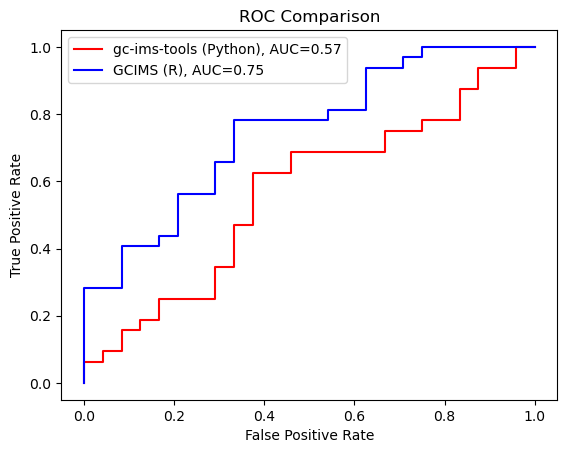

In [7]:
fprP, tprP, tP= metrics.roc_curve(predP["Label"],predP[0],drop_intermediate=False)
fprR, tprR, tR = metrics.roc_curve(predR["Label"],predR[0],drop_intermediate=False)
plt.plot(fprP,tprP,label="gc-ims-tools (Python), AUC="+str(round(AUCP, 2)),color='r')
plt.plot(fprR,tprR,label="GCIMS (R), AUC="+str(round(AUCR, 2)),color='b')
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison")
plt.legend()

## PERMUTATION TEST

In [8]:
# Function to generae each model with a random test label
def permutation(data,lvh,i):
    Xtrain=data.loc[data["id"]!=i].drop(["labels","id"],axis=1).values.tolist()
    Xtest=data.loc[data["id"]==i].drop(["labels","id"],axis=1).values.tolist()
    Ytrain=data.loc[data["id"]!=i]["labels"].values.tolist()
    groups = np.unique(Ytrain)
    Ytest=rd.sample(groups.tolist(),1)*len(Xtest)
    LV=lvh[np.unique(data["id"]).tolist().index(i)]
    pls=PLSRegression(n_components=LV, scale=True)
    pls.fit(Xtrain,Ytrain)
    predPer=pd.DataFrame(pls.predict(Xtest))
    predPer["Label"]=Ytest
    return predPer

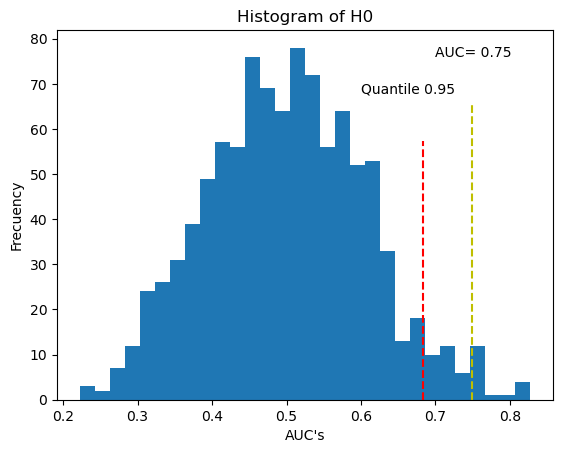

Confidence interval for the permutation test: [0.328 - 0.683]
AUC R: 0.7486979166666667
p-value: 0.017


In [9]:
permutR=[]
for j in range(1000):
    predPer = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(permutation)(dataR, lvhR, i) for i in np.unique(dataR["id"]))
    pred=pd.DataFrame()
    for k in range(len(predPer)):
        pred=pd.concat([pred,predPer[k]])
    permutR.append(metrics.roc_auc_score(pred["Label"],pred[0]))
sorted_permut = np.array(permutR)
sorted_permut.sort()
confidence_lower = sorted_permut[int(0.05 * len(sorted_permut))]
confidence_upper = sorted_permut[int(0.95 * len(sorted_permut))]
plt.hist(permutR, bins=30)
plt.title('Histogram of H0')
plt.axvline(x=confidence_upper, ymax=0.7, color='r',linestyle="--")
plt.axvline(x=metrics.roc_auc_score(predR['Label'],predR[0]), ymax=0.8, color="y",linestyle="--")
plt.ylabel("Frecuency")
plt.xlabel("AUC's")
plt.text(0.6,68,"Quantile 0.95")
plt.text(0.7,76,f"AUC= {round(metrics.roc_auc_score(predR['Label'],predR[0]),2)}")
plt.show()
print("Confidence interval for the permutation test: [{:0.3f} - {:0.3}]".format(confidence_lower, confidence_upper))    
print(f"AUC R: {metrics.roc_auc_score(predR['Label'],predR[0])}")
print(f"p-value: {len(np.where(np.array(permutR)>=metrics.roc_auc_score(predR['Label'],predR[0]))[0])/1000}")